# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [27]:
# Importing the packages for the needed libraries for the Jupyter notebook
import inspect 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [28]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


In [29]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in part 01 we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [30]:
# Select features for training data
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [31]:
# Display the first 5 rows of the selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (1.61s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1714914000000,2024-05-05 13:00:00+00:00,2024-05-05,13,0.01447,14.6,78.0,0.1,0.1,0.0,51.0,100.0,10.4,27.0,6,5,5,2024,0
1,1714946400000,2024-05-05 22:00:00+00:00,2024-05-05,22,0.73648,9.9,92.0,0.6,0.6,0.0,53.0,100.0,15.5,31.7,6,5,5,2024,0
2,1714906800000,2024-05-05 11:00:00+00:00,2024-05-05,11,0.02678,16.1,67.0,0.0,0.0,0.0,3.0,95.0,14.0,28.4,6,5,5,2024,0
3,1714950000000,2024-05-05 23:00:00+00:00,2024-05-05,23,0.66137,9.8,92.0,0.1,0.1,0.0,51.0,100.0,13.0,26.6,6,5,5,2024,0
4,1714910400000,2024-05-05 12:00:00+00:00,2024-05-05,12,0.02372,15.7,71.0,0.0,0.0,0.0,3.0,98.0,13.7,29.5,6,5,5,2024,0


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

We can specify next parameters:

- `name` - Name of the feature view to create.

- `version` - Version of the feature view to create.

- `query` - Query object with the data.

In [32]:
# Getting or creating a feature view named 'electricity_feature_view'
version = 1
feature_view_training = fs.get_or_create_feature_view(
    name='electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

Training datasets can include various splits, such as:

Training set: This subset of the training data is utilized for model training.
Validation set: Used for evaluating hyperparameters during model training.
Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

**Training Dataset  may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training.
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.create_training_dataset()` method.

**From feature view APIs you can also create training datasets based on event time filters specifying `start_time` and `end_time`**

In [33]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
X, _ = feature_view_training.training_data(
    description = 'Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.36s) 


In [34]:
# Show the information for the training data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             14 non-null     int64  
 1   datetime              14 non-null     object 
 2   date                  14 non-null     object 
 3   hour                  14 non-null     int64  
 4   dk1_spotpricedkk_kwh  14 non-null     float64
 5   temperature_2m        14 non-null     float64
 6   relative_humidity_2m  14 non-null     float64
 7   precipitation         14 non-null     float64
 8   rain                  14 non-null     float64
 9   snowfall              14 non-null     float64
 10  weather_code          14 non-null     float64
 11  cloud_cover           14 non-null     float64
 12  wind_speed_10m        14 non-null     float64
 13  wind_gusts_10m        14 non-null     float64
 14  dayofweek             14 non-null     int64  
 15  day                   14 

### <span style="color:#2656a3;"> ⛳️ Dataset with train, test and validation splits</span>

In [35]:
# Drop the columns 'date', 'datetime', and 'timestamp' from the DataFrame 'X'
X = X.drop(columns=['date', 'datetime', 'timestamp'])

In [36]:
# Remove the target variable 'dk1_spotpricedkk_kwh' from the DataFrame 'X' and assign it to the variable 'y'.
y = X.pop('dk1_spotpricedkk_kwh')

In [37]:
# Importing function for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the features (X) and the target variable (y) into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 20% of data will be used for testing 
    random_state=42, # Random seed for reproducibility
)

In [38]:
# Display the first 5 rows of the features in the training data
X_train.head()

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
12,7,13.0,92.0,0.0,0.0,0.0,3.0,97.0,5.8,12.6,6,5,5,2024,0
5,3,10.7,99.0,0.0,0.0,0.0,3.0,98.0,4.7,10.1,6,5,5,2024,0
8,1,11.3,99.0,0.0,0.0,0.0,3.0,97.0,2.5,11.5,6,5,5,2024,0
2,12,15.7,71.0,0.0,0.0,0.0,3.0,98.0,13.7,29.5,6,5,5,2024,0
1,11,16.1,67.0,0.0,0.0,0.0,3.0,95.0,14.0,28.4,6,5,5,2024,0


In [39]:
# Display the first 5 rows of the target variable in the training data
y_train.head()

12    0.41083
5     0.60036
8     0.63266
2     0.02372
1     0.02678
Name: dk1_spotpricedkk_kwh, dtype: float64

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the XGBoost Regressor.

The XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting. Specifically tailored for regression tasks, it aims to predict continuous numerical values. The algorithm constructs an ensemble of regression trees, optimizing them to minimize a specified loss function, commonly the mean squared error for regression tasks. Ultimately, the final prediction is derived by aggregating the predictions of individual trees.

In [40]:
# Importing the XGBoost Regressor
import xgboost as xgb

# Initialize the XGBoost Regressor
model = xgb.XGBRegressor()

In [41]:
# Train the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#ff5f27'> ⚖️ Model Validation

In [42]:
# Importing the model validation metric functions from the sklearn library
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [43]:
# Predict target values on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("⛳️ R^2:", r2)

# Calculate Mean Absolute Error (MAE) using sklearn
mae = mean_absolute_error(y_test, y_pred)
print("⛳️ MAE:", mae)

⛳️ MSE: 0.0022177377982979555
⛳️ RMSE: 0.0470928635601824
⛳️ R^2: 0.9708110687368887
⛳️ MAE: 0.04100086918206374


**Mean Squared Error (MSE):**
- Measures the average squared difference between the actual and predicted values in a regression problem. 
- It squares the differences between predicted and actual values to penalize larger errors more heavily.
- Lower MSE values indicate better model performance, so an MSE of 0.0023 indicates a fairly good model performance.

**Root Mean Squared Error (RMSE):**
- The Root Mean Squared Error is the square root of the Mean Squared Error.
- RMSE is a more interpretable metric than MSE because it is in the same units as the target variable.
- Like MSE, lower RMSE values indicate better model performance.

**R-squared (R²):**
- Measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features) in a regression model.
- R-squared values range from 0 to 1, where 0 indicates that the model does not explain any variability in the target variable, and 1 indicates that the model explains all the variability.
- R-squared is a useful metric for assessing how well the regression model fits the observed data. However, it does not provide information about the goodness of fit on new, unseen data.

**Mean Absolute Error (MAE):**
- Measures the average absolute difference between the actual and predicted values.
- MAE is less sensitive to outliers compared to MSE because it does not square the errors.
- Like MSE and RMSE, lower MAE values indicate better model performance.

MSE and RMSE focus on the magnitude of errors, while R-squared provides insight into the proportion of variance explained by the model. MAE provides a measure of average error without considering the direction of errors.


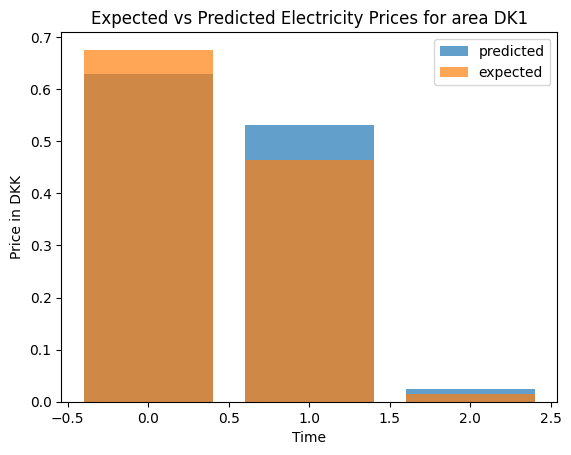

In [44]:
# Plot the predictions against the expected values
plt.title('Expected vs Predicted Electricity Prices for area DK1')

# Plot the predicted values
plt.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)

# Plot the expected values
plt.bar(x=np.arange(len(y_pred)), height=y_test, label='expected', alpha=0.7)

# Add labels to the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Price in DKK')

# Add a legend and display the plot
plt.legend()
plt.show() 

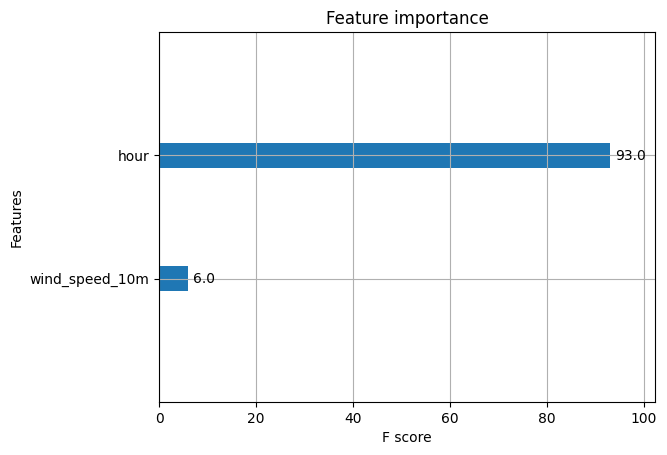

In [45]:
# Import the plot_importance function from XGBoost
from xgboost import plot_importance

# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    model, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

## <span style='color:#2656a3'>🗄 Model Registry</span>
The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. WE can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

In [46]:
# Importing the libraries for saving the model
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [47]:
# Retrieving the Model Registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

In databases, a schema acts as a blueprint that visually represents how data is -- or will be -- organized within a database. Also, the activity of data modeling in a database leads to the creation of a schema.

In [48]:
# Specify the schema of the model's input and output using the features (X_train) and target variable (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Create a model schema using the input and output schemas
model_schema = ModelSchema(input_schema, output_schema)

In [49]:
# Define the directory path where the trained model will be exported
model_dir = "model"

# Check if the directory already exists, if not create it
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [50]:
# Save the XGBoost Regressor as joblib file in the model directory
joblib.dump(model, model_dir + "/dk_electricity_model.pkl")

['model/dk_electricity_model.pkl']

In [51]:
# Create an entry in the model registry with the specified details
xgb_model = mr.python.create_model(
    name="electricity_price_prediction_model", # Name of the model
    metrics={ # Evaluation metrics for the model
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2,
        "MAE": mae,
    },
    model_schema=model_schema, # Schema defining the input and output data structure of the model
    input_example=X_train.sample(), # Example input data for the model
    description="DK1 Electricity Price Predictor" # Description of the model
)

In [52]:
# Upload the model to hopsworks
xgb_model.save(model_dir)

Uploading: 100.000%|██████████| 80357/80357 elapsed<00:01 remaining<00:001,  3.73it/s]
Uploading: 100.000%|██████████| 82/82 elapsed<00:01 remaining<00:0002<00:05,  1.26s/it]
Uploading: 100.000%|██████████| 1271/1271 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.83s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/550040/models/electricity_price_prediction_model/3


Model(name: 'electricity_price_prediction_model', version: 3)

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.